# Imports, Settings and loading Data

In [1]:
# This is an example of an successful execution of the TICC algorithm on the UEA BasicMotions dataset.
# It does not include the data preparation of the Delhi Climate nor of the Occupancy dataset.

import numpy as np
import sys
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import math
import random
from scipy.io.arff import loadarff 
import sklearn.metrics as sk_metrics

from tslearn import clustering
from sktime.classification.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from IPython.display import clear_output

from TICC.TICC_solver import TICC

# custom for progress bar
from tqdm.notebook import tqdm, tnrange

%load_ext autoreload
%autoreload 2

%matplotlib notebook
%matplotlib inline

dataset_name = 'BasicMotions'

pd.set_option('display.max_rows', 6)
fname = "df_out.csv"
data_path = 'datasets/UEA_Multivariate2018_arff/%s/%s.arff'
dataset_path = data_path % (dataset_name, dataset_name + '_TRAIN')

raw_data = loadarff(dataset_path)
df_raw = pd.DataFrame(raw_data[0])
sample_count = len(df_raw)
df_raw

s:\development\bachelorarbeit\venv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


,relationalAtt,activity
0,"[[0.079106, 0.079106, -0.903497, 1.116125, 1.6...",b'Standing'
1,"[[0.377751, 0.377751, 2.952965, 4.310925, 3.25...",b'Standing'
2,"[[-0.813905, -0.813905, -0.424628, 0.316895, 0...",b'Standing'
...,...,...
37,"[[1.142016, 1.142016, 0.840727, -0.013852, -0....",b'Badminton'
38,"[[-0.39606, -0.39606, -0.268022, 0.353698, 0.0...",b'Badminton'
39,"[[1.211973, 1.211973, -0.605948, 0.476761, 2.5...",b'Badminton'


In [2]:
data_column_name = 'relationalAtt'
validation_column_name = 'activity'

data = [list() for i in range(len(df_raw[data_column_name]))]
labels = [label.decode("utf-8") for label in df_raw[validation_column_name]]

for i, row in enumerate(df_raw[data_column_name]):
    for column in row:
        data[i].append(column)
    label_scaled = [labels[i] for j in range(len(column))] # get same number of labels in array as data; transpose the array later on 
    data[i].append(label_scaled)

column_count = len(data[0])
column_labels = [] # option to assign custom labels (list of strings)
if column_labels == []:
    column_labels = [str(i) for i in range(1, column_count)]
column_labels.append("validation")

rows_to_drop = []

df_new = pd.DataFrame(data, columns = column_labels) # each row represents one sample. each field represents the content of the column in this sample
df_new

,1,2,3,4,5,6,validation
0,"[0.079106, 0.079106, -0.903497, 1.116125, 1.63...","[0.394032, 0.394032, -3.666397, -0.656101, 1.4...","[0.551444, 0.551444, -0.282844, 0.333118, 0.39...","[0.351565, 0.351565, -0.095881, 1.624657, 1.18...","[0.02397, 0.02397, -0.319605, -0.569962, -0.27...","[0.633883, 0.633883, 0.972131, 1.209171, 1.739...","[Standing, Standing, Standing, Standing, Stand..."
1,"[0.377751, 0.377751, 2.952965, 4.310925, 3.256...","[-0.61085, -0.61085, 0.970717, -1.625661, -6.9...","[-0.147376, -0.147376, -5.962515, -1.898794, -...","[-0.103872, -0.103872, -7.593275, -5.345389, -...","[-0.109198, -0.109198, -0.697804, 0.402169, 0....","[-0.037287, -0.037287, -2.865789, -4.176168, -...","[Standing, Standing, Standing, Standing, Stand..."
2,"[-0.813905, -0.813905, -0.424628, 0.316895, 0....","[0.825666, 0.825666, -1.305033, -0.507693, 0.0...","[0.032712, 0.032712, 0.82617, 0.218569, 0.5863...","[0.021307, 0.021307, -0.372872, 0.02397, 0.066...","[0.122515, 0.122515, -0.045277, -0.130505, -0....","[0.775041, 0.775041, 0.383526, 0.588605, 0.817...","[Standing, Standing, Standing, Standing, Stand..."
...,...,...,...,...,...,...,...
37,"[1.142016, 1.142016, 0.840727, -0.013852, -0.1...","[1.018433, 1.018433, -2.015249, -0.92355, -0.2...","[0.677593, 0.677593, -0.742828, -0.614269, -2....","[0.175783, 0.175783, 1.61134, 1.222488, 0.8549...","[-0.460763, -0.460763, -1.35832, -0.769715, -0...","[0.67916, 0.67916, 2.615432, 1.675261, 1.32103...","[Badminton, Badminton, Badminton, Badminton, B..."
38,"[-0.39606, -0.39606, -0.268022, 0.353698, 0.01...","[-0.686878, -0.686878, 0.10351, 0.251851, 0.67...","[-0.350328, -0.350328, -1.281489, -1.933435, -...","[-0.157139, -0.157139, 0.274327, -0.311615, -0...","[-0.058594, -0.058594, -0.471417, -0.535338, -...","[0.151812, 0.151812, 0.332922, 0.082565, 0.114...","[Badminton, Badminton, Badminton, Badminton, B..."
39,"[1.211973, 1.211973, -0.605948, 0.476761, 2.50...","[-0.247107, -0.247107, -3.855673, -5.442304, 0...","[0.327837, 0.327837, 7.113185, 3.593358, -1.67...","[0.058594, 0.058594, 0.90022, -0.865596, 0.250...","[-0.527348, -0.527348, -1.32636, -0.993438, -0...","[-0.042614, -0.042614, -0.095881, 1.12927, 1.8...","[Badminton, Badminton, Badminton, Badminton, B..."


# Merging and Shuffeling Samples (only .arff datasets)

['Standing', 'Walking', 'Standing', 'Walking', 'Badminton', 'Running', 'Badminton', 'Standing', 'Badminton', 'Running', 'Running', 'Badminton', 'Standing', 'Walking', 'Standing', 'Walking', 'Badminton', 'Standing', 'Walking', 'Walking', 'Badminton', 'Badminton', 'Badminton', 'Running', 'Walking', 'Walking', 'Standing', 'Running', 'Running', 'Standing', 'Badminton', 'Standing', 'Walking', 'Running', 'Walking', 'Running', 'Standing', 'Running', 'Badminton', 'Running']


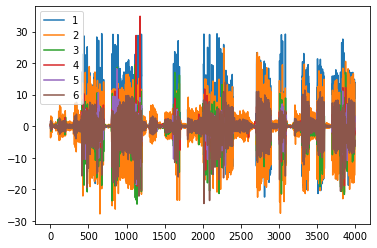

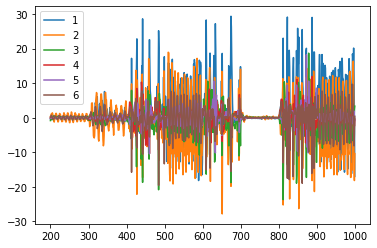

In [3]:
random_sequence = True

sequenz_labels = []
sample = df_new.loc[0] # get content of first row in dataframe
sample_transposed = map(list, zip(*sample)) # transpose list
df = pd.DataFrame(sample_transposed, columns = column_labels)
sequenz_labels.append(labels[0])

r = list(range(1, sample_count))
if random_sequence:
    random.shuffle(r)

for i in r:
    sample = df_new.loc[i]
    sample_transposed = map(list, zip(*sample))
    df_temp = pd.DataFrame(sample_transposed, columns = column_labels)
    df = df.append(df_temp, ignore_index=True)
    sequenz_labels.append(labels[i])

    
# assigning each label a number (for calculating accuracy later on)
cluster_ids = {}
for i, label in enumerate(set(sequenz_labels)):
    cluster_ids[label] = i
    
validation_labels = df["validation"]
validation_labels_in_numbers = []
for i in range(len(validation_labels)):
    validation_labels_in_numbers.append(cluster_ids[validation_labels[i]])
    
#df.plot();
print(sequenz_labels)
df.plot()
df[200:1000].plot();

In [4]:
normalize = False 
split_til_end = True
testing_split_start = 0
testing_split_end = 1000
if split_til_end:
    testing_split_end = len(df)
    
if len(rows_to_drop) > 0:
    df_out = df.drop(columns=['validation']).drop(columns=rows_to_drop)[testing_split_start:testing_split_end]
    df_out.plot()
else:
    df_out = df.drop(columns=['validation'])[testing_split_start:testing_split_end]

if normalize:
    # min-max normalization
    df_out=(df_out-df_out.min())/(df_out.max()-df_out.min())
    
df_out.to_csv(fname, header=False, index=False)
#df_out.drop(columns=['meanpressure']).plot();
#df_out.plot();
#len(df_out)

# Running TICC

4 Clusters


Training Iteration - (max 10):   0%|          | 0/10 [00:00<?, ?it/s]

Clusteroptimierung:   0%|          | 0/4 [00:00<?, ?it/s]

Clusteroptimierung:   0%|          | 0/4 [00:00<?, ?it/s]

Clusteroptimierung:   0%|          | 0/4 [00:00<?, ?it/s]

Clusteroptimierung:   0%|          | 0/4 [00:00<?, ?it/s]

Clusteroptimierung:   0%|          | 0/4 [00:00<?, ?it/s]

Clusteroptimierung:   0%|          | 0/4 [00:00<?, ?it/s]



Converged! (breaking early)



TRAINING F1 scores:
EM (expectation maximization): 0.44
GMM (Gaussian mixture model): 0.26
k-Means: 0.26


BIC: 12963.93
runtime: 4.2 seconds


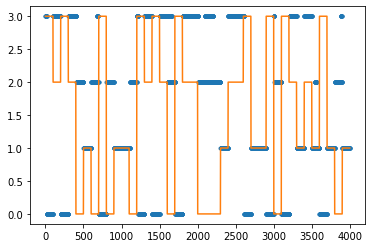

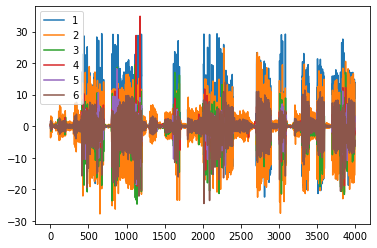

In [5]:
window_size = 1
beta = 50 # 600
number_of_clusters = len(set(validation_labels_in_numbers[testing_split_start:testing_split_end])) # get the number of clusters that are in the split
print(str(number_of_clusters) + " Clusters")

ticc = TICC(window_size=window_size, number_of_clusters=number_of_clusters, lambda_parameter=11e-2, beta=beta, maxIters=10, threshold=2e-5,
            write_out_file=True, prefix_string="output_folder/", num_proc=1, compute_BIC=True)

time1 = time.time() * 1000
(cluster_assignment, cluster_MRFs, BIC) = ticc.fit(input_file=fname)
time2 = time.time() * 1000
print("BIC: " + str(round(BIC, 2)))
    #np.savetxt('Results.txt', cluster_assignment, fmt='%d', delimiter=',')

print('runtime: ' + str(round((time2-time1)/1000, 2)) + ' seconds')

plt.plot(cluster_assignment, '.');
#plt.plot(cluster_assignment, '-');
plt.plot(validation_labels_in_numbers[testing_split_start:testing_split_end]);
df[testing_split_start:testing_split_end].plot();

In [6]:
km = clustering.TimeSeriesKMeans(n_clusters=number_of_clusters, metric="euclidean", max_iter=10)

time1 = time.time() * 1000

km.fit(df_out)
km_prediction = km.predict(df_out)

time2 = time.time() * 1000

print('runtime: ' + str(round((time2-time1)/1000, 2)) + ' seconds')

runtime: 2.04 seconds


s:\development\bachelorarbeit\venv\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


# Calculating Accuracy

--- TICC ---
AR Score              : 0.83
NMI Score             : 0.82
Silhouette Score      : -0.04
CH Score              : 116.29
DB Score              : 6.53
--- k-Means ---
AR Score              : 0.1
NMI Score             : 0.22
Silhouette Score      : 0.44
CH Score              : 1223.72
DB Score              : 1.43


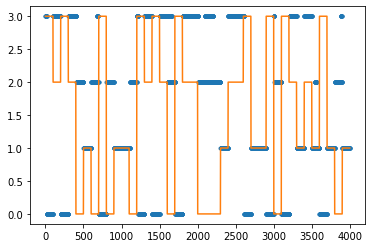

In [7]:
validation_labels_shortened = validation_labels_in_numbers[testing_split_start:testing_split_end]
if window_size > 1: # when windows size > 1, a part of output gets cut
    validation_labels_same_length = validation_labels_shortened[:-(window_size-1)]
    df_score_calc = df_out[:-(window_size-1)]
else:
    validation_labels_same_length = validation_labels_shortened
    df_score_calc = df_out
    
plt.plot(cluster_assignment, '.')
plt.plot(validation_labels_same_length)

# calculating scores 

# TICC
accuracy_rs = sk_metrics.adjusted_rand_score(validation_labels_same_length, cluster_assignment) # keep track of windows size! 
accuracy_mis = sk_metrics.normalized_mutual_info_score(validation_labels_same_length, cluster_assignment, average_method='arithmetic')
silhouette_score = sk_metrics.silhouette_score(df_score_calc, labels=cluster_assignment, metric='euclidean')
ch_score = sk_metrics.calinski_harabasz_score(df_score_calc, labels=cluster_assignment)
db_score = sk_metrics.davies_bouldin_score(df_score_calc, labels=cluster_assignment)

print('--- TICC ---')
# external validators
print('AR Score              : ' + str(round(accuracy_rs, 2))) # 1.0 is a perfect match
print('NMI Score             : ' + str(round(accuracy_mis, 2))) # 1.0 is a perfect match
# internal validators
print('Silhouette Score      : ' + str(round(silhouette_score, 2))) # the best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
print('CH Score              : ' + str(round(ch_score, 2))) # the ratio between the within-cluster dispersion and the between-cluster dispersion.
print('DB Score              : ' + str(round(db_score, 2))) # the lower the values, the better the clustering


# k-Means
accuracy_rs = sk_metrics.adjusted_rand_score(validation_labels_same_length, km_prediction)
accuracy_mis = sk_metrics.normalized_mutual_info_score(validation_labels_same_length, km_prediction, average_method='arithmetic')
silhouette_score = sk_metrics.silhouette_score(df_score_calc, labels=km_prediction, metric='euclidean')
ch_score = sk_metrics.calinski_harabasz_score(df_score_calc, labels=km_prediction)
db_score = sk_metrics.davies_bouldin_score(df_score_calc, labels=km_prediction)

print('--- k-Means ---')
# external validators
print('AR Score              : ' + str(round(accuracy_rs, 2))) # 1.0 is a perfect match
print('NMI Score             : ' + str(round(accuracy_mis, 2))) # 1.0 is a perfect match
# internal validators
print('Silhouette Score      : ' + str(round(silhouette_score, 2))) # the best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
print('CH Score              : ' + str(round(ch_score, 2))) # the ratio between the within-cluster dispersion and the between-cluster dispersion.
print('DB Score              : ' + str(round(db_score, 2))) # the lower the values, the better the clustering

#clear_output(wait=True)


In [12]:
## TO BE IGNORED

In [140]:
# sktime classification for comparison
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sktime.classification.compose import (
    ColumnEnsembleClassifier,
    TimeSeriesForestClassifier,
)
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator



X = df_out
columns_names = list(df_out.columns.values)
nested_set = {}
for c in columns_names:
    nested_set[c] = np.asarray(df_out[c], dtype=np.float32)

nested_df = pd.DataFrame(nested_set)
X = nested_df
#print(nested_df)

#X = np.asarray(X, dtype=np.float32)
#print(X)
y = validation_labels_in_numbers[testing_split_start:testing_split_end]
y = np.asarray(y, dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y)

steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


ValueError: If passed as a pd.DataFrame, X must be a nested pd.DataFrame, with pd.Series or np.arrays inside cells.

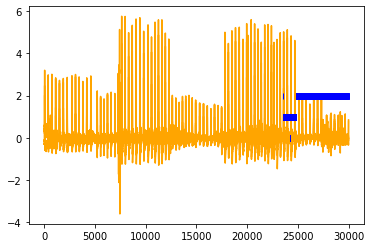

In [125]:
# position splitted part in whole time series
indexed_cluster_assignment = [None for i in range(testing_split_end)]
for i in range(testing_split_start, testing_split_end):
    indexed_cluster_assignment[i] = cluster_assignment[i-testing_split_start-window_size] # depending on window size, some data gets cut off
    
plt.plot(df.drop(columns=['validation']), 'orange')
plt.plot(indexed_cluster_assignment, 'b|')

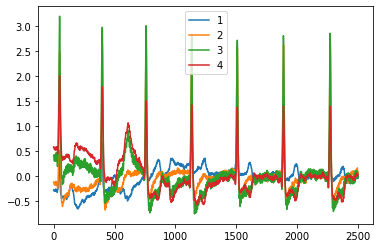

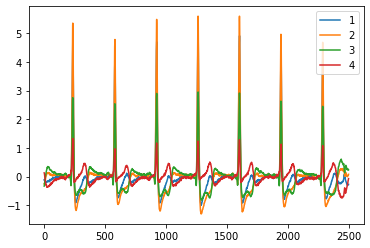

In [126]:
sample_1 = df_new.loc[0] # get content of first row in dataframe
sample_1_transposed = map(list, zip(*sample_1)) # transpose list
df = pd.DataFrame(sample_1_transposed, columns = ['1', '2', '3', '4', '5'])
df.plot();
sample_2 = df_new.loc[11]
sample_2_transposed = map(list, zip(*sample_2)) # transpose list
df2 = pd.DataFrame(sample_2_transposed, columns = ['1', '2', '3', '4', '5'])
df2.plot();